# TM10007 Group 4 -- ECG Data
Lara, Josefien, Merel, Amber Liqui Lung (44646168)

In this assignment we wil test certain classifiers in order to create a classifier model to distinguish between normal and abnormal ECG's. The code is divided in different segments that are explained in our report.

In [45]:
# Loading packages
import zipfile
import os
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pylab as pl
import plotly.express as px

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import set_config


from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

pd.set_option('display.max_rows', 5)

# #Create interactive plots in order to be able to turn around 3d plots
# #You need ipympl package for this, if you don't have it use !pip install ipympl and refresh
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()


## 1. Data loading 

Below we load the ECG data, convert it to a dataframe an clean the data. First we are going to start with loading the CS file into a dataframe

In [46]:
# Load CSV file into dataframe
!git clone https://github.com/JosefienBerg/TM10007_ML_ECG_group4.git

with zipfile.ZipFile('/content/TM10007_ML_ECG_group4/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/TM10007_ML_ECG_group4/ecg')

df = pd.read_csv('/content/TM10007_ML_ECG_group4/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(df.index)}')
print(f'The number of columns: {len(df.columns)}')

fatal: destination path 'TM10007_ML_ECG_group4' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


Now we are going to test if there is data missing in our dataset. We conclude that NaNs are missing data and if an entire row or column has zero's, this is also seen as missing data.

In [4]:
# Checking if there are any NaN or None values in the dataset
print(f'Are there any NaN or None values in the dataset? = '+ str(df.isnull().values.any()))

Are there any NaN or None values in the dataset? = False


In [5]:
# # Test dataset for missing rows/columns

# # Columns
# columnswithzeros = []
# for (colname, colval) in df.iteritems():
#   if (colval.to_numpy()==0).all() == True:
#     print(f'All values are zero in column {colname}')
#     columnswithzeros.append(colname)

# if len(columnswithzeros) == 0:
#   print('There are no columns with only zeros')
  
# # Rows
# rowswithzeros = []
# for (index, rowval) in df.iterrows():
#   if (rowval.to_numpy()==0).all() == True: 
#     print(f'All values are zero in row {index}')
#     rowswithzeros.append(index)

# if len(rowswithzeros) == 0:
#   print('There are no rows with only zeros')

There are no columns with only zeros
There are no rows with only zeros


Lasty we are going to check if there are patiens or features with multiple zeros in order to see if those zero's could represent missing data

In [6]:
# # Test patients with multiple zero's 
# def check_for_zeros_in_patients(dataframe): 
#   patients_with_zeros=[]
#   for (index, rowval) in dataframe.iterrows():
#     row = rowval.to_numpy()[:-1] #change to numpy to delete row names en the last row of labels
#     if (row==0).any() == True: #if there is a zero in the row
#       number_of_zeros = 0
#       for i in range(len(row)): #check the entire length of the row for
#         if row[i] == 0:
#           number_of_zeros += 1
#       patients_with_zeros.append({"patient number": index, "number of zeros": number_of_zeros}) 
#   print(patients_with_zeros)
#   print(f' There are {len(patients_with_zeros)} patients with zeros')

# check_for_zeros_in_patients(df)

# # Test features with multiple zero's
# def check_for_zeros_in_features(dataframe):
#   features_with_zeros = []
#   for (colname, colval) in dataframe.iteritems():
#     if colname == "label": #don't check the column label
#       continue
#     col = colval.to_numpy()
#     if (col==0).any() == True: 
#       number_of_zeros = 0
#       for i in range(len(col)):
#         if col[i] == 0:
#           number_of_zeros += 1
#       features_with_zeros.append({"feature": colname, "number of zeros": number_of_zeros}) 

#   print(features_with_zeros)
#   print(f'There are {len(features_with_zeros)} features with zeros')

# check_for_zeros_in_features(df)

[{'patient number': 177, 'number of zeros': 750}, {'patient number': 251, 'number of zeros': 750}, {'patient number': 269, 'number of zeros': 750}, {'patient number': 321, 'number of zeros': 750}, {'patient number': 323, 'number of zeros': 750}, {'patient number': 385, 'number of zeros': 750}, {'patient number': 434, 'number of zeros': 750}, {'patient number': 446, 'number of zeros': 750}, {'patient number': 537, 'number of zeros': 750}, {'patient number': 542, 'number of zeros': 750}, {'patient number': 575, 'number of zeros': 750}, {'patient number': 601, 'number of zeros': 750}, {'patient number': 784, 'number of zeros': 750}, {'patient number': 790, 'number of zeros': 750}]
 There are 14 patients with zeros
[{'feature': '6_0', 'number of zeros': 1}, {'feature': '6_1', 'number of zeros': 1}, {'feature': '6_2', 'number of zeros': 1}, {'feature': '6_3', 'number of zeros': 1}, {'feature': '6_4', 'number of zeros': 1}, {'feature': '6_5', 'number of zeros': 1}, {'feature': '6_6', 'number

Conclusion: there are patients with multiple zero's (14 with 750 zero's), however these are not centered at certain features. This means that these zero's could indeed represent missing data and are therefore be replaced with the mean of that feature for the label of that patient.


In [7]:
# # Create a list of means per label and feature
# df_normal = df[df["label"]== 0]
# df_abnormal = df[df["label"]== 1]
# df_normal_mean = {}
# df_abnormal_mean = {}

# for (colname, colval) in df_normal.iteritems():
#   if colname == "label":
#     continue
#   df_normal_mean[colname] = (colval.to_numpy().mean())

# for (colname, colval) in df_abnormal.iteritems():
#    if colname == "label":
#      continue
#    df_abnormal_mean[colname] = (colval.to_numpy().mean())

# print(df_normal_mean)
# print(df_abnormal_mean)

{'0_0': 469.3470502749906, '0_1': 70.6996088100883, '0_2': 40.62862319412772, '0_3': 31.173712757341196, '0_4': 31.54865255065674, '0_5': 43.429041907720126, '0_6': 55.84330178557533, '0_7': 39.003234790730296, '0_8': 25.226056527835073, '0_9': 19.172557363950904, '0_10': 22.256479757512093, '0_11': 26.297794080493855, '0_12': 30.72142554697234, '0_13': 31.66812879477023, '0_14': 30.372431869497436, '0_15': 31.39360833307335, '0_16': 33.352713458528626, '0_17': 34.58298517061866, '0_18': 38.503790736701596, '0_19': 38.319370868571966, '0_20': 43.68758295776539, '0_21': 35.40656152935558, '0_22': 34.785388992521355, '0_23': 35.78567016939342, '0_24': 34.731802677249625, '0_25': 30.919289833729547, '0_26': 28.888807336884312, '0_27': 25.994899925065507, '0_28': 25.159825027510696, '0_29': 25.99326216312191, '0_30': 28.119506596374972, '0_31': 30.27387223375175, '0_32': 31.95308050038741, '0_33': 30.74525789346074, '0_34': 31.30504561055703, '0_35': 31.8473466118405, '0_36': 32.1852669540

In [8]:
# # Replace zeros with the correct mean of that feature and label
# cleaned_data = df.copy().to_numpy() #make a copy of original data and change into numpy array

# column_names = list(df.columns.values) #make a list of the column names

# for i in range(len(cleaned_data)):
#   for j in range(len(cleaned_data[0])-1):
#     if cleaned_data[i,j] == 0:
#       label = cleaned_data[i,-1]
#       if label == 0:
#         col_name = column_names[j]
#         cleaned_data[i,j] = df_normal_mean[col_name]
#       else:
#         col_name = column_names[j]
#         cleaned_data[i,j] = df_abnormal_mean[col_name]

# # Change back from numpy array to dataframe and check if there are no zeros left and the dimension are the same
# cleaned_df = pd.DataFrame(cleaned_data, columns = column_names)
# print(f'The number of samples: {len(cleaned_df.index)}')
# print(f'The number of columns: {len(cleaned_df.columns)}')
# check_for_zeros_in_patients(cleaned_df)
# check_for_zeros_in_features(cleaned_df)

The number of samples: 827
The number of columns: 9001
[]
 There are 0 patients with zeros
[]
There are 0 features with zeros


Lastly we want to categorize our dataset to see how many patients have a normal and how many patients have an abnormal ECG. 


In [9]:
# # How many patients have a normal or abnormal ECG?
# count0= (cleaned_df['label'] == 0).sum()
# count1= (cleaned_df['label'] == 1).sum()
# print(f'There are {count0} patients with label 0')
# print(f'There are {count1} patients with label 1')
# # Since the majority of patients has no abnormalities we can conclude that label 0 is normal and label 1 is abnormal

There are 681 patients with label 0
There are 146 patients with label 1


## 2. Initial split
Below we split the dataset in test data and training data. 

In [73]:
# Split the whole data set in a training and test set
features = df.loc[:, df.columns !="label"].to_numpy()
labels = df["label"].to_numpy()

x_train, x_test, y_train, y_test = train_test_split (features, labels, train_size = 0.8, random_state = 42) 
print(f"The training set has {x_train.shape[0]} samples and {x_train.shape[1]} features with {y_train.shape[0]} labels")
print(f"The test has {x_test.shape[0]} samples and {x_test.shape[1]} features with {y_test.shape[0]} labels")

The training set has 661 samples and 9000 features with 661 labels
The test has 166 samples and 9000 features with 166 labels


## 3. Data scaling, PCA and feature selection
In this section we will explore multiple scaling methods, determine if we will use PCA and define the treshold and we will explore mutliple feature selection methods. After this section we will have a dictionary containing the x_train data for all combinations of the chosen scaling, PCA and selection methods.


There are multiple ways to scale features. Since the feature distribution is unclear, we will use normalization.

In [74]:
# 1. Standardization of the data
scaler_standard = StandardScaler()
x_scaled_standard = scaler_standard.fit_transform(x_train) 

# 1. Min-max scaling
scaler_minmax = MinMaxScaler()
x_scaled_minmax = scaler_minmax.fit_transform(x_train)

# # 2. Robust scaling --> Robust is removed due to a to extensive loading time during the training of SVC
# scaler_robust= RobustScaler()
# x_scaled_robust = scaler_robust.fit_transform(x_train)

x_scaled = {"standard":x_scaled_standard, "minmax":x_scaled_minmax}


Now we are going to perform PCA and determine the treshold.

(661, 275)


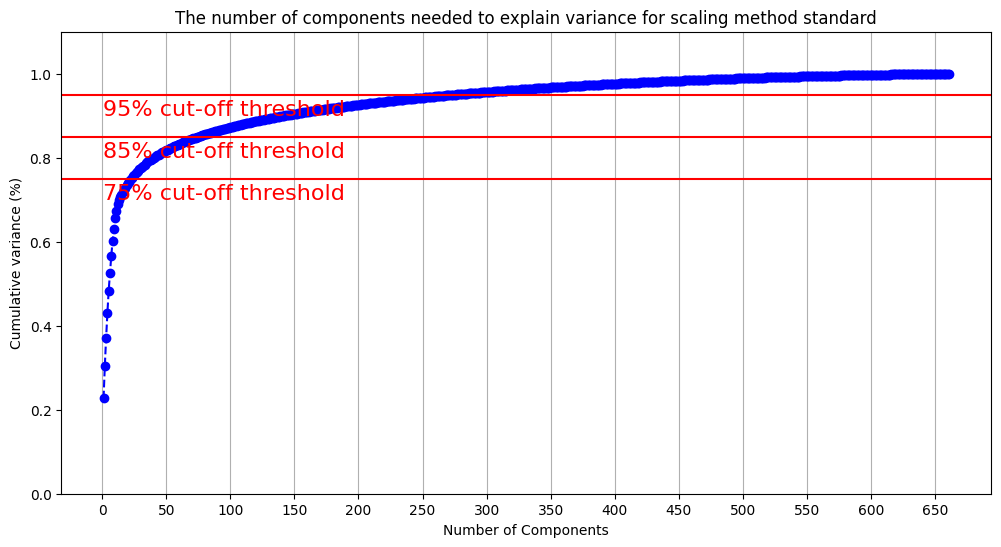

(661, 306)


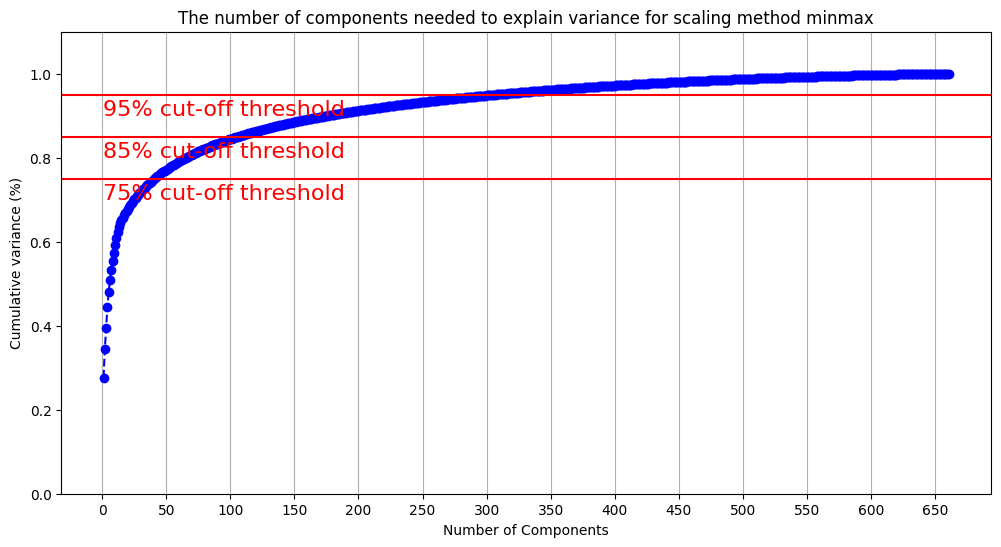

In [75]:
# PCA
plt.close('all') #before plotting, close all old windows
x_scaled_pca = {} #create dictionary to add all combinations of scaling combined with PCA to

for key, x in x_scaled.items():
    
    # applying pca
    pca_setting = PCA(n_components = 0.95) # threshold at 95% method
    x_pca = pca_setting.fit_transform(x)
    x_scaled_pca[f"x_{key}_PCA"] = x_pca

    print(x_pca.shape)

    # plot to show treshold choice
    pca_figure = PCA().fit(x)
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 662, step=1)
    y = np.cumsum(pca_figure.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, 661, step=50)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title(f'The number of components needed to explain variance for scaling method {key}')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)

    plt.axhline(y=0.85, color='r', linestyle='-')
    plt.text(0.5, 0.8, '85% cut-off threshold', color = 'red', fontsize=16)

    plt.axhline(y=0.75, color='r', linestyle='-')
    plt.text(0.5, 0.7, '75% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()

Lasty we will look at feature selection. 

In [87]:
# Feature selection with and without PCA
x_scaled_selected = {} #create dictionary to add all combinations of scaling with or without PCA combined with feature selection

selector = SelectKBest(f_classif)
k = 50

#Including PCA
for key, x in x_scaled_pca.items():
    selector.k = k
    x_train_ffs = selector.fit_transform(x_train, y_train)  # ffs = f-test feature selection
x_scaled_selected[f"{key}_ffs"] =  x_train_ffs

#Exclusing PCA
for key, x in x_scaled.items():
    selector.k = k
    x_train_ffs = selector.fit_transform(x_train, y_train)  # ffs = f-test feature selection
x_scaled_selected[f"x_{key}_ffs"] =  x_train_ffs

Now we finish with a dictionary x_scaled_selected that inclused all combinations between feature scaling, feature extraction (PCA) and feature selection

## 4. Standard classifiers: hyperparameter tuning and fitting
In this section we will train our different clasiffiers and compare their functionality in terms of F1 and average precision. We will perform this for all possible combinations of scaling, selection and classification possibilities. This is also the section were we will tune our parameters.

First we are going to set the models and parameters we are going to tune and write the function for tuning. 

In [94]:
# Creating a dictionary of all proposed classifiers
models = {"GaussianNB": GaussianNB(),
          "KNeighborsClassifier": KNeighborsClassifier(),
          "RandomForestClassifier":RandomForestClassifier(),
          "SVC":SVC()
          }

# Creating a dictionary of all models with default paramters (note; random state=42 only added in the last run)
model_parameters = {"GaussianNB": {}, #no parameters to be set
                    "KNeighborsClassifier":{"n_neighbors":[x for x in range(20, 300)], "weights": ["distance", "uniform"]},
                    "RandomForestClassifier":{"n_estimators":[x for x in range(5,10)], "max_depth":[x for x in range (1,20)], "min_samples_leaf": [x for x in range (1, 20)]},
                    "SVC":{"C": np.logspace(-2, 5, num=10), "kernel": ["linear", "rbf", "poly"], "degree":[x for x in range (2,4)]}
                    }

# Function to clean up results and create dataframe with wanted results
def get_dataframe_from_results(results, scoring):
  """ This function makes sure that we can clean up the results that we get from the grid search and leaves is with the necessary results"""
  df_to_concat = [pd.DataFrame(results["params"])]

  for key in scoring:
    df_to_concat.append(pd.DataFrame(results[f"mean_test_{key}"], columns=[key]))

  return pd.concat(df_to_concat, axis=1)

# Function to do a grid search on each model using the parameters in the model_parameter dictionary
def parametertuning(Models, ModelParameters, n_splits, random_state, scoring, refit, X, Y):
  """ This function performs the parameter tuning by doing a gridsearch with multiple parameters per model it returns the results that are cleaned up and only show the necessary"""
  results = {} #create a dictionary to save results

  for model_name, parameters in ModelParameters.items():
    print(f"Grid searching {model_name}")
    model = Models[model_name]  # Find corresponding model in models dict

    # Create the Cross vallidation object
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)  
    
    # Perform a grid search for the best parameters for the model using the test data and KFold
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring, refit=refit).fit(X, Y) 
    
    # Results of grid search
    best_estimator = grid_search.best_estimator_ # Returns the model with the best parameters filled in based on refit scoring metric
    grid_search_results = get_dataframe_from_results(grid_search.cv_results_, scoring) # Extracts the necessary results 

    # Add the results to the dictionary
    results[model_name] = {"BestEstimator": best_estimator, "GSresults": grid_search_results}
 
  return results

Now we are going write the function to plot the relation between the scoring type and certain parameters in order to prove that we chose the right parameter combinations.

In [90]:
# Since we do not tune any paramters in GaussianNB we don't need to make a plot

#---------------Plot for KNeighborsClassifier---------------
def plot_knn(results, scoring, combination_name):
  knn_df = results["KNeighborsClassifier"]["GSresults"]
  uni_knn_df = knn_df[knn_df["weights"] == "uniform"]
  dist_knn_df = knn_df[knn_df["weights"] == "distance"]

  for key in scoring:
    index_maxscore = knn_df[key].idxmax()

    # pl.figure(f"KNeighborsClassifier, {combination_name}, {key}")
    plt.plot(uni_knn_df["n_neighbors"].to_numpy(), uni_knn_df[key].to_numpy(), label= "uniform")
    plt.plot(dist_knn_df["n_neighbors"].to_numpy(), dist_knn_df[key].to_numpy(), label= "distance")
    plt.scatter(knn_df["n_neighbors"][index_maxscore], knn_df[key].max(), s= 200, marker = "*", c="m")

    plt.legend()
    plt.title(f"The relation between the {key} of the KNN classifier and the parameters {combination_name}")
    plt.xlabel("N-neighbour")
    plt.ylabel(f"{key}")
    plt.show()

#---------------Plot for SVC Classifier--------------- 
def plot_svc(results, scoring, combination_name):
  svc_df = results["SVC"]["GSresults"]
  linear_svc_df = svc_df[svc_df["kernel"]=="linear"]
  rbf_svc_df = svc_df[svc_df["kernel"]=="rbf"]
  poly_svc_df = svc_df[svc_df["kernel"]=="poly"]

  for key in scoring:
    index_maxscore = svc_df[key].idxmax()

    # pl.figure(f"SVC Classifier, {combination_name}, {key}")
    for i in range(2,5):
      degree_svc_df = poly_svc_df[poly_svc_df["degree"]==i]
      plt.plot(degree_svc_df["C"].to_numpy(), degree_svc_df[key].to_numpy(), label= f"poly degree {i}")

    plt.plot(linear_svc_df["C"].to_numpy(), linear_svc_df[key].to_numpy(), label= "linear")
    plt.plot(rbf_svc_df["C"].to_numpy(), rbf_svc_df[key].to_numpy(), label= "rbf")
    plt.scatter(svc_df["C"][index_maxscore], svc_df[key].max(), s = 200, marker = "*", c="m")

    plt.legend()
    plt.title(f"The relation between the {key} of the SVC classifier and the parameters {combination_name}")
    plt.xscale("log")
    plt.xlabel("C-value")
    plt.ylabel(f"{key}")
    plt.show()

# ---------------Plots for RandomForestClassifier---------------
def plot_randomforest(results, scoring, combination_name):
  forest_df = results["RandomForestClassifier"]["GSresults"]

  for key in scoring:
    # fig = plt.figure(f"Random Forest Classifier, {combination_name}, {key}")
    # ax = fig.add_subplot(111, projection = '3d')
    index_maxscore = forest_df[key].idxmax() #index (number of the row)

    # x = forest_df["max_depth"].to_numpy()
    # y = forest_df["min_samples_leaf"].to_numpy()
    # z = forest_df["n_estimators"].to_numpy()
    # c = forest_df[key].to_numpy()

    fig = px.scatter_3d(forest_df, x="max_depth", y="min_samples_leaf", z="n_estimators", color=key,  title=f"The relation between the {key} of the Random Forest and the parameters {combination_name}")
    fig.add_traces(px.scatter_3d(forest_df.sample[key].loc[index_maxscore], x="max_depth", y="min_samples_leaf", z="n_estimators").update_traces(marker_size=20, marker_color="yellow").data)
    # px.scatter_3d(forest_df["max_depth"][index_maxscore], forest_df["min_samples_leaf"][index_maxscore], forest_df["n_estimators"][index_maxscore], marker = "*", s= 200, c= 'm')

    # plt.title()
    # fig.colorbar(img, pad=0.1)
    # ax.set_xlabel("max_depth")
    # ax.set_ylabel("min_samples_leaf")
    # ax.set_zlabel("n_estimators")

    fig.show()

Beneath, we write the function to display the best scoring results for each model.

In [91]:
# Plot tabel with scoring metric and optimal paramater combination per scalor and selection
def create_table_of_results(results_all_combinations, combination_name):
  F1_scores = []
  Average_Precision_scores = []
  model_names = [] 

  results = results_all_combinations[combination_name]

  for model_name in results:
    F1 = results[model_name]["GSresults"]["F1"].max()
    Average_Precision = results[model_name]["GSresults"]["Average Precision"].max()
    print(F1)
    print(Average_Precision)
    F1_scores.append(F1)
    Average_Precision_scores.append(Average_Precision)
    model_names.append(model_name)

  print(f"Table of results for combination {combination_name}")
  display(pd.DataFrame({"ModelName":model_names, "F1":F1_scores, "Average Precision":Average_Precision_scores}).style.hide(axis='index'))
  print()

Lastly, we will call all functions written to tune all the parameters and plot the results for each combination of scaling, PCA and selection.

In [95]:
# Perform training
results_all_combinations = {}
for combination_name, data in x_scaled_selected.items():
  print(combination_name)
  
  # Perform grid search
  scoring = {"F1":"f1", "Average Precision":"average_precision"} #Determine what type of scoring you want to use
  results = parametertuning(models, model_parameters, 5, None, scoring, "Average Precision", data, y_train)
  results_all_combinations[combination_name] = results


x_minmax_PCA_ffs
Grid searching GaussianNB
Grid searching KNeighborsClassifier
Grid searching RandomForestClassifier


KeyboardInterrupt: ignored

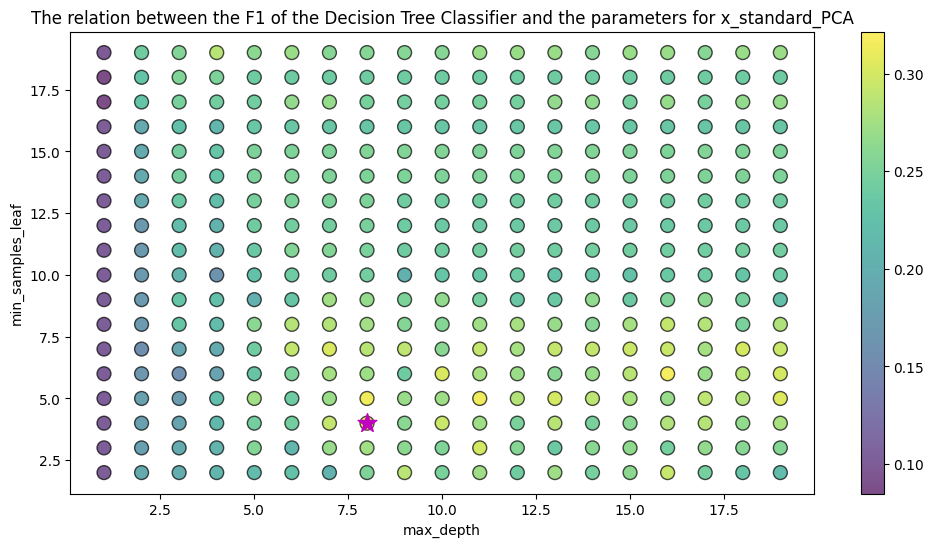

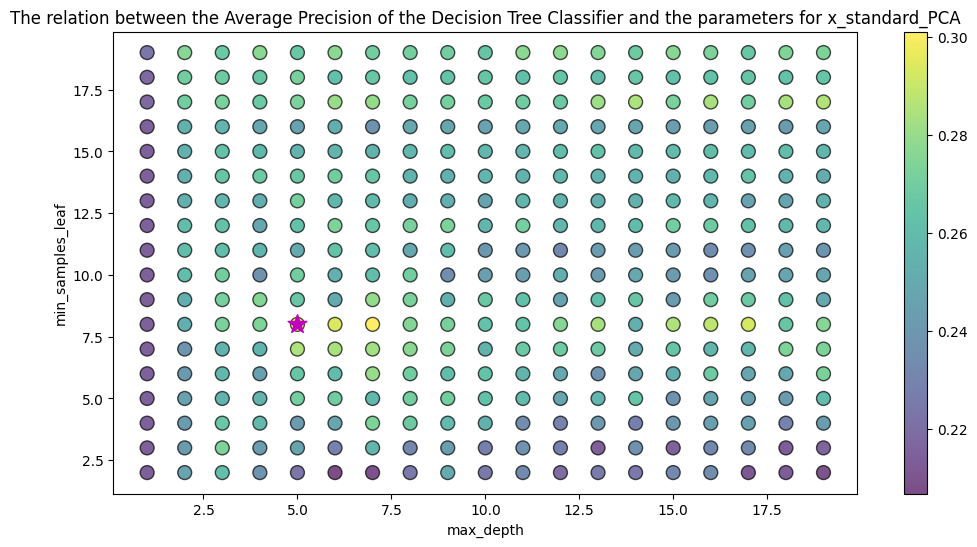

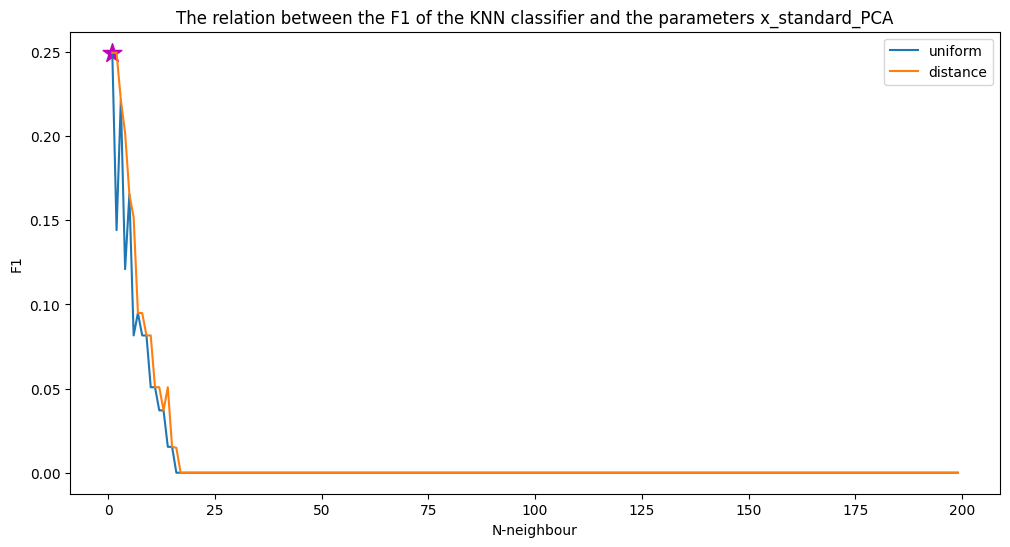

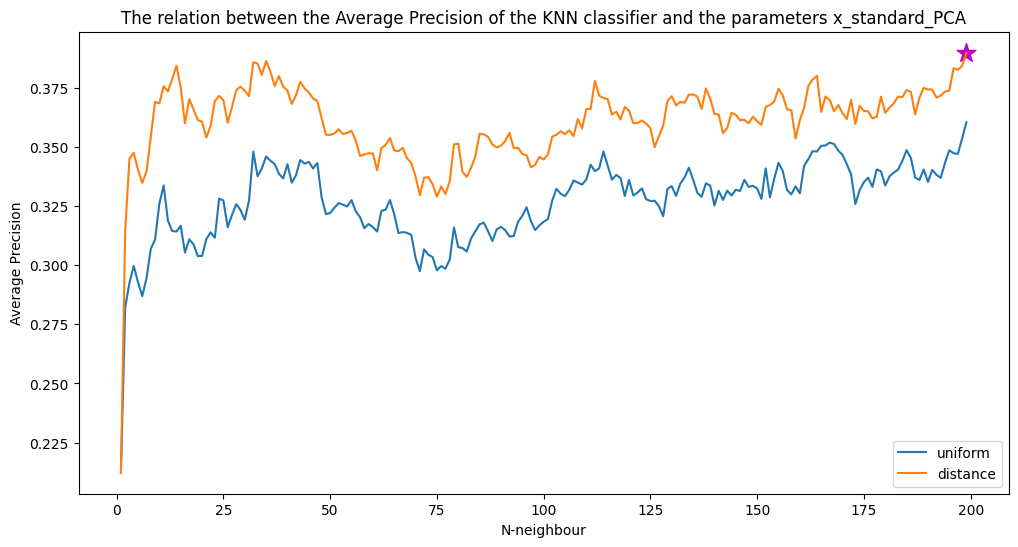

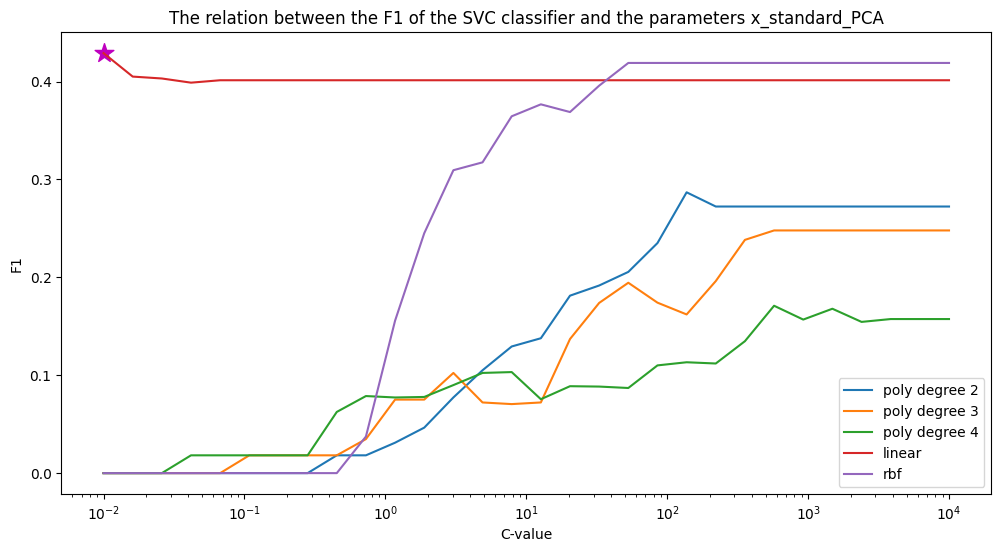

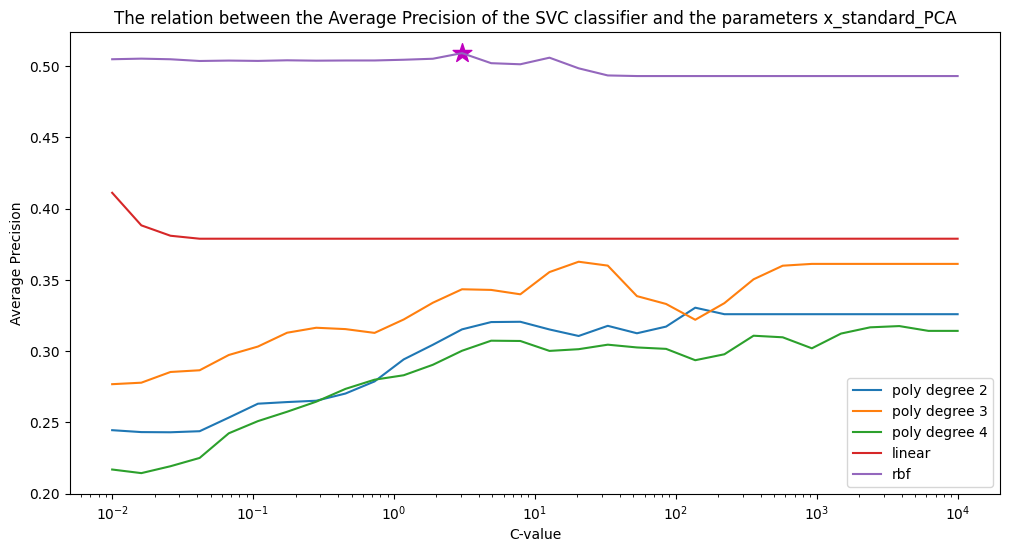

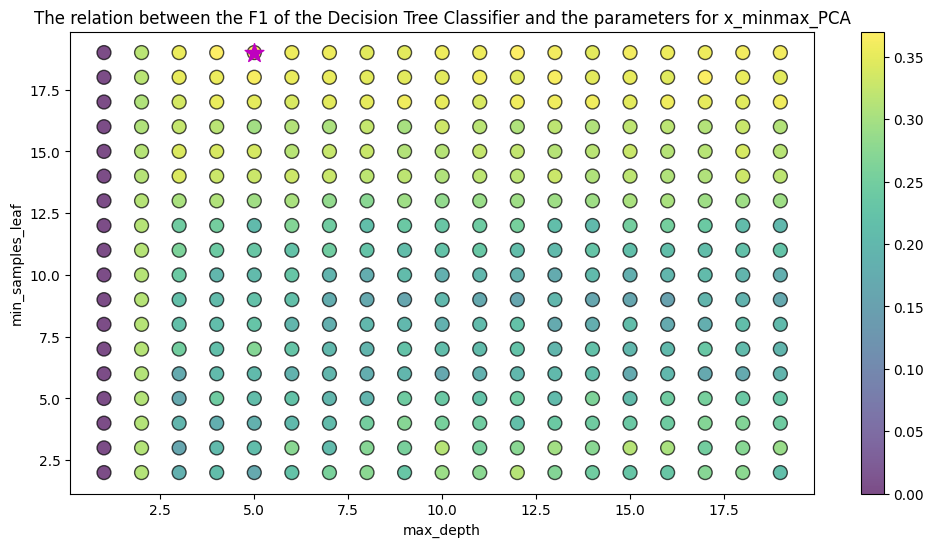

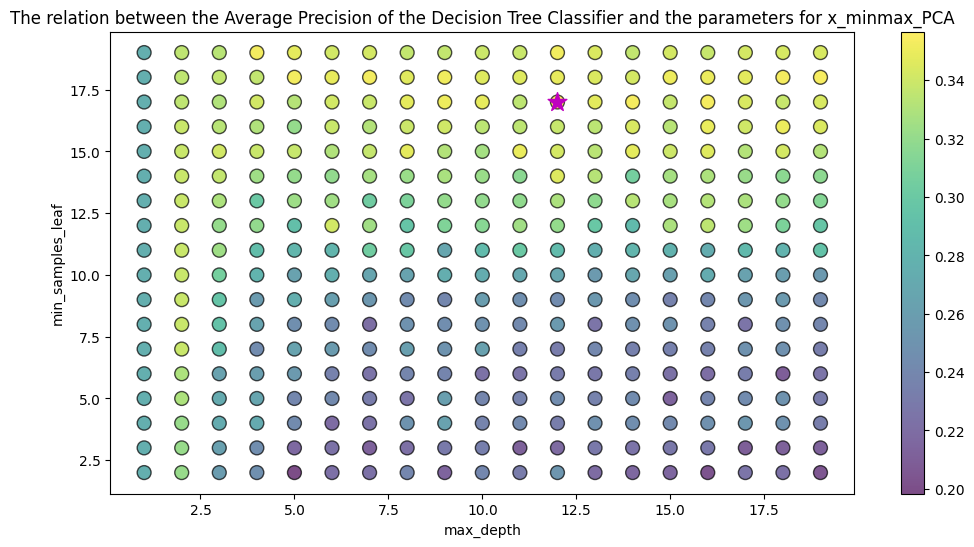

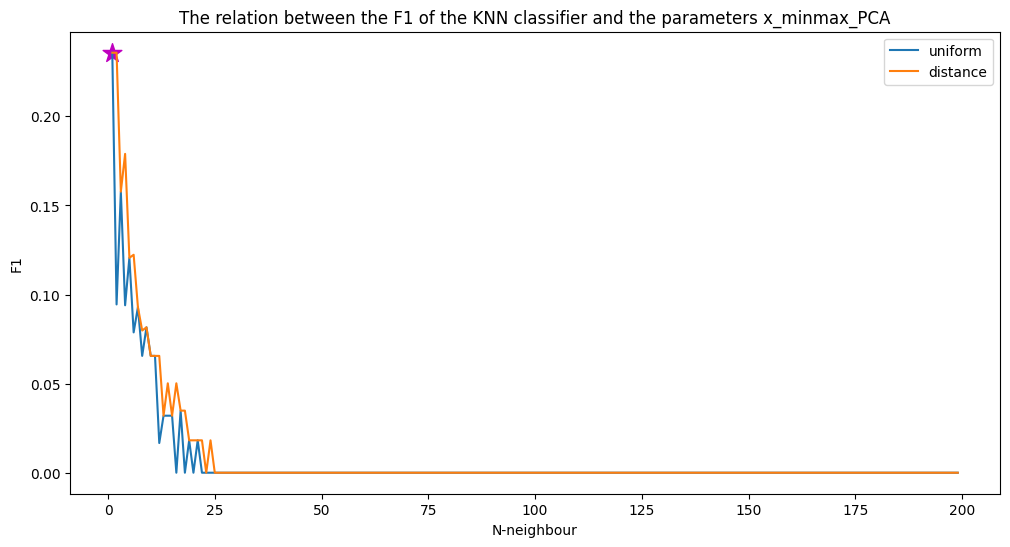

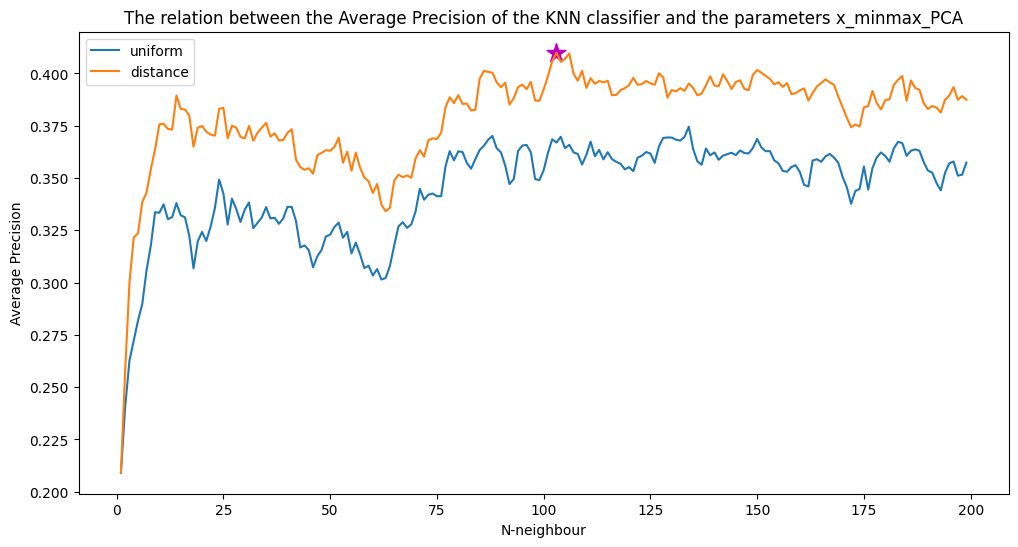

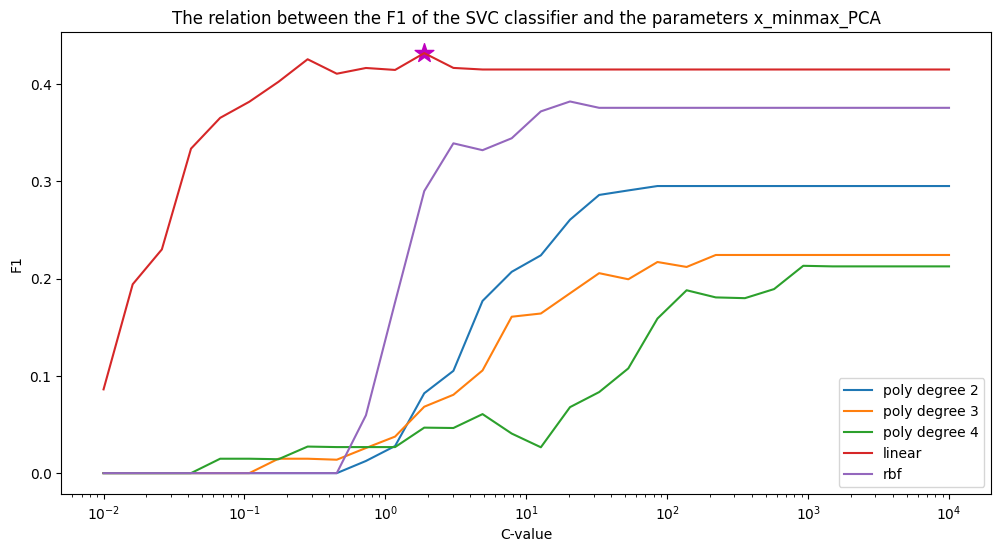

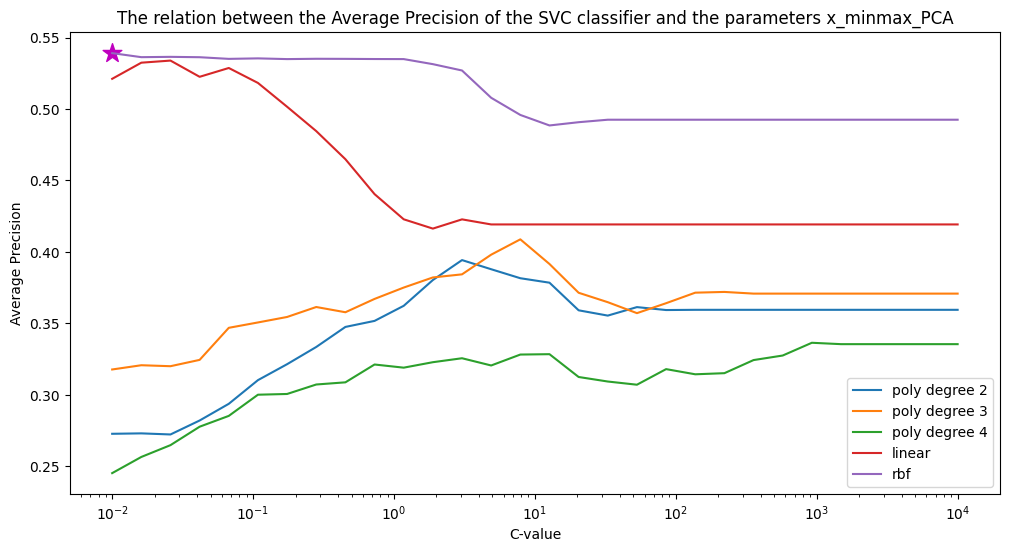

In [41]:
# Create visualization of results 
plt.close('all') #make sure you class all windows before plotting to prevent plotting in the same figure

for combination_name, data in x_scaled_pca.items():

  #Create all plots to show the relation between the scoring type and parameters for every combination
  plot_knn(results_all_combinations[combination_name], scoring, combination_name)
  plot_svc(results_all_combinations[combination_name], scoring, combination_name)
  plot_randomforest(results_all_combinations[combination_name], scoring, combination_name)

In [42]:
# Create table with results for every combination
for combination_name, data in x_scaled_pca.items():
  create_table_of_results(results_all_combinations, combination_name)

0.3220435990767806
0.2881571973736639
0.3215002064058668
0.3010444654226532
0.24952930724044556
0.38974979545240446
0.26437889595784336
0.42799242582384844
0.4290920532901927
0.5090276798502795
Table of results for combination x_standard_PCA


ModelName,F1,Average Precision
GaussianNB,0.322044,0.288157
DecisionTreeClassifier,0.321500,0.301044
KNeighborsClassifier,0.249529,0.389750
RandomForestClassifier,0.264379,0.427992
SVC,0.429092,0.509028



0.30363190687144015
0.28486061820675823
0.3701514244584386
0.35667169674708826
0.2357015177982403
0.409924569558245
0.26636221003358357
0.3990012919668713
0.43199752139695546
0.5390966538787968
Table of results for combination x_minmax_PCA


ModelName,F1,Average Precision
GaussianNB,0.303632,0.284861
DecisionTreeClassifier,0.370151,0.356672
KNeighborsClassifier,0.235702,0.409925
RandomForestClassifier,0.266362,0.399001
SVC,0.431998,0.539097


## 5. A neural network

## 6. The final model 
After the previous steps we determined the best combination of scaling, PCA, feature selection and classification for our final model. Underneath we wrote the final pipeline that returns the mean accuracy of the model on the test data.

In [ ]:
# # Write final pipeline with chosen combinations
# def final_pipeline(x_train, y_train, x_test, y_test):

#   # Determine steps of the pipeline
#   pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components = 0.95)), ('svc', SVC(C=1, kernel= "rbf"))])

#   # Visualize the pipeline
#   set_config(display = "diagram")
#   pipe

#   # Fit the pipeline on the training data 
#   pipe.fit(x_train, y_train)

#   # Compute the mean accuracy of the model on the test data
#   score = pipe.score(x_test, y_test) #Returns the mean accuracy of the model on test data
#   return score

# #Execute pipeline to get the mean accuracy of the final model on the test data
# accuracy = final_pipeline(x_train, y_train, x_test, y_test)
# print(f"The accuracy of the final model on the test data is {accuracy}")

